# Project 

This is the project for course EE4540 Distributed Signal Processing.

Environment:

Python = 3.12

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.colors import LinearSegmentedColormap
# import seaborn as sns
import time
import random

## Q1

In [2]:
# 复制过来

## Q2
Averaging
### randomised gossip

In [3]:
# randomised gossip

# 设置随机种子
np.random.seed(42)
random.seed(42)



In [4]:
# 随机Gossip算法实现
def randomised_gossip(init_values, adj_matrix, global_avg, max_iterations=5000, convergence_threshold=1e-6):
    """实现随机Gossip算法计算平均值"""
    # 全局平均值仅用于验证，实际分布式算法中不用

    values = init_values.copy()
    n = len(values)
    
    # 初始化历史记录
    history = {
        # 'node_values': [],
        # 'avg_estimates': [],
        'errors': [],
        'transmissions': 0
    }
    
    # 初始状态
    # history['node_values'].append(np.array([graph.nodes[i]['value'] for i in graph.nodes]))
    # history['avg_estimates'].append(np.array([graph.nodes[i]['avg_value'] for i in graph.nodes]))
    history['errors'].append(np.sum((values - global_avg) ** 2))
    
    iteration = 0
    
    while iteration < max_iterations:
        # 随机选择一个节点
        node_i = random.randint(0, n - 1)
        
        # 随机选择一个邻居
        neighbors = [idx for idx, connected in enumerate(adj_matrix[node_i]) if connected]
        if not neighbors:
            continue
        node_j = random.choice(neighbors)
        
        # 交换值并更新
        value_i = values[node_i]
        value_j = values[node_j]
        
        # 计算平均值
        new_value = (value_i + value_j) / 2.0
        
        # 更新两个节点的值
        values[node_i] = new_value
        values[node_j] = new_value
        
        # 记录传输次数
        history['transmissions'] += 2  # 双向通信

        iteration += 1
        
        # 记录当前状态
        if iteration % 10 == 0:  # 每10次迭代记录一次
            # current_values = np.array([graph.nodes[i]['avg_value'] for i in graph.nodes])
            # history['node_values'].append(current_values.copy())
            # history['avg_estimates'].append(np.mean(current_values))
            current_error = np.sum((values - global_avg) ** 2)
            history['errors'].append(current_error)
            
            # 检查收敛
            if current_error < convergence_threshold:
                break
        
    return values, history



随机生成结点和相应联通边

n=120 r=30

In [5]:
# Definition of the sizes
Area_Length = 100              # The length of the area, both length and width are the same
Area_Size = Area_Length ** 2
Area_Coverage = 0.999          # Define the total coverage of the sensors
Connected_Prob = 0.99

In [6]:
n = 50                   # Number of sensors
Comm_Radius = 40          # Communication radius of each sensor

sensor_location = np.random.uniform(0, Area_Length, (n, 2))

# Calculate Euclidean distance matrix
Euc_matrix = distance_matrix(sensor_location, sensor_location)

# Calculate adjacency matrix
adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)
print(adj_matrix)

# Build network graph
Graphs = nx.Graph()
for i in range(n):
    Graphs.add_node(i, pos = tuple(sensor_location[i]))

for j in range(n):
    for k in range (j+1, n):
        if adj_matrix[j,k]:
            Graphs.add_edge(j, k)
print(f"Network connected: {nx.is_connected(Graphs)}")
print(f"Number of edges: {Graphs.number_of_edges()}")

[[False False False ... False False False]
 [False False False ...  True  True False]
 [False False False ... False False  True]
 ...
 [False  True False ... False  True False]
 [False  True False ...  True False False]
 [False False  True ... False False False]]
Network connected: True
Number of edges: 395


In [7]:
# 初始值
init_values = np.random.uniform(20, 30, n)
global_avg = np.mean(init_values)
print(f"Global average: {global_avg:.4f}")


Global average: 24.7830


In [8]:
# 运行随机Gossip算法
print("\nRunning randomised gossip algorithm...")
start_time = time.time()
final_values, history = randomised_gossip(init_values, adj_matrix, global_avg, max_iterations=3000)
elapsed_time = time.time() - start_time

# 输出结果
final_avg = np.mean(final_values)
final_error = history['errors'][-1]  # 最后一次记录的误差

print("\nAlgorithm completed!")
print(f"Total iterations: {len(history['errors'])*10}")
print(f"Total transmissions: {history['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_avg:.8f}")
print(f"Global average: {global_avg:.8f}")
print(f"Absolute error: {abs(final_avg - global_avg):.8f}")
print(f"Mean square error: {final_error:.8f}")
# print(f"Converged: {'Yes' if converged else 'No'}")



Running randomised gossip algorithm...

Algorithm completed!
Total iterations: 3010
Total transmissions: 6000
Execution time: 0.0209 seconds
Final estimated average: 24.78299917
Global average: 24.78299917
Absolute error: 0.00000000
Mean square error: 0.00000164


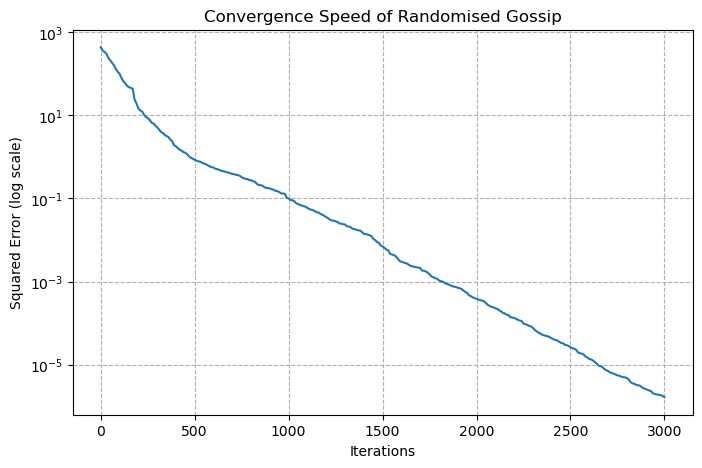

In [9]:
# convergence speed
# 绘制收敛速度图
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history['errors'])) * 10, history['errors'])
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed of Randomised Gossip')
plt.grid(True, which="both", ls="--")
plt.show()

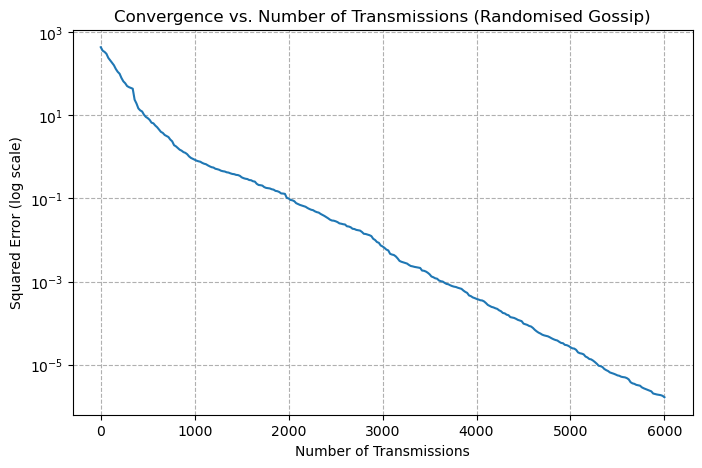

In [10]:
# number of transmissions
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history['errors'])) * 10 * 2, history['errors'])
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence vs. Number of Transmissions (Randomised Gossip)')
plt.grid(True, which="both", ls="--")
plt.show()

### PDMM

## Q3